# 🌿 Classification Binaire de Formes de Feuilles avec PyTorch

## 📋 Présentation du Projet
Ce projet explore la **classification binaire** à l'aide de réseaux de neurones profonds (Deep Learning) avec la bibliothèque **PyTorch**.
L'objectif est de prédire l'architecture d'une feuille (Classe `0` ou `1`) en fonction de ses caractéristiques géométriques (longueur, largeur, etc.).

Le dataset utilisé est `leafshape17.csv`, contenant des mesures morphologiques de différentes feuilles.

## 🎯 Objectifs Pédagogiques
Ce notebook met en œuvre les étapes clés d'un projet de Data Science :
1.  **Préparation des données :** Chargement, nettoyage et **mélange aléatoire (Shuffling)** indispensable pour éviter les biais.
2.  **Modélisation :** Comparaison de deux approches :
    * approche **Linéaire** (Régression Logistique).
    * approche **Non-Linéaire** (Réseau de Neurones / MLP).
3.  **Entraînement :** Utilisation de la descente de gradient (Optimiseur **Adam**) et de la fonction de coût **BCELoss**.
4.  **Évaluation :** Analyse des courbes de *Loss*, calcul de la précision (*Accuracy*) et prévention du sur-apprentissage (*Overfitting*).

## 🛠️ Technologies Utilisées
* **Python**
* **PyTorch** (Création des modèles et tensors)
* **Pandas** (Manipulation des données CSV)
* **Matplotlib** (Visualisation des courbes d'apprentissage)

## 📊 Résultats Clés
* L'importance du **Shuffling** a été démontrée (passage de ~45% à ~100% de précision).
* Comparaison des performances :
    * **Régression Logistique :** 100% de précision (Le problème est linéairement séparable).
    * **Réseau de Neurones (16 neurones cachés) :** 100% de précision (Modèle plus complexe, capable de capturer des subtilités fines).
* **Conclusion :** Pour ce dataset spécifique, le modèle simple (Régression Logistique) est suffisant (Principe de Parcimonie).



In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import TensorDataset,DataLoader
from torch.nn import Module, Linear, Sigmoid , BCELoss, ReLU
from torch.optim import Adam
import torch.nn.functional as F
import torch.nn as nn

In [2]:
df = pd.read_csv('leafshape17.csv')
print(df.info())
df.head()

<class 'pandas.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  61 non-null     int64  
 1   bladelen    61 non-null     float64
 2   petiole     61 non-null     float64
 3   bladewid    61 non-null     float64
 4   latitude    61 non-null     float64
 5   logwid      61 non-null     float64
 6   logpet      61 non-null     float64
 7   loglen      61 non-null     float64
 8   arch        61 non-null     int64  
dtypes: float64(7), int64(2)
memory usage: 4.4 KB
None


,Unnamed: 0,bladelen,petiole,bladewid,latitude,logwid,logpet,loglen,arch
0,186,6.93,0.449064,3.10,17.1,1.131402,-0.800590,1.935860,0
1,187,7.27,0.261720,2.50,17.1,0.916291,-1.340480,1.983756,0
2,188,7.43,0.766033,2.98,17.1,1.091923,-0.266530,2.005526,0
3,189,8.00,0.592800,3.06,17.1,1.118415,-0.522898,2.079442,0
4,190,8.08,0.492900,3.03,17.1,1.108563,-0.707449,2.089392,0


In [ ]:
X_df = df.drop(['Unnamed: 0','arch'],axis=1)
y_series = df['arch']
X_tensor = torch.tensor(X_df.values,dtype=torch.float32)
y_tensor = torch.tensor(y_series.values,dtype=torch.float32)
torch.manual_seed(42)
indices = torch.randperm(len(X_tensor))
X_shuffled = X_tensor[indices]
Y_shuffled = y_tensor[indices]
# 4. On coupe : 50 pour Entraînement / Le reste (11) pour Test
n_train = 50
train_dataset = TensorDataset(X_shuffled[:n_train], Y_shuffled[:n_train])
test_dataset  = TensorDataset(X_shuffled[n_train:], Y_shuffled[n_train:])

# 5. On crée les Chargeurs (Loaders) qui serviront pour TOUS les modèles
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [4]:
class RegressionLogistique(Module):
    def __init__(self,input_dim):
        super(RegressionLogistique,self).__init__()
        self.linear = Linear(input_dim,1)
        self.activation = Sigmoid()
    def forward(self,x):
        x = self.linear(x)
        x = self.activation(x)
        return x
p = 7 
modele = RegressionLogistique(p)

print(modele)

RegressionLogistique(
  (linear): Linear(in_features=7, out_features=1, bias=True)
  (activation): Sigmoid()
)


In [5]:
critere = BCELoss()

# 2. On choisit Adam (souvent plus stable que SGD) avec un taux d'apprentissage de 0.01
optimiseur = Adam(modele.parameters(), lr=0.01)

print("Configuration terminée : BCELoss et Adam prêts.")

Configuration terminée : BCELoss et Adam prêts.


In [6]:
num_epochs = 200
loss_history = []
print("Début de l'entrainement...")
for epoch in range(num_epochs):
    epoch_loss = 0.00
    for i, (X, Y) in enumerate(train_loader):
        optimiseur.zero_grad()
        outputs = modele(X)
        loss = critere(outputs, Y.view(-1,1))
        loss.backward()
        optimiseur.step()

        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Époque {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

print("Entraînement terminé !")

Début de l'entrainement...
Époque 10/200, Loss: 0.3997
Époque 20/200, Loss: 0.4136
Époque 30/200, Loss: 0.4565
Époque 40/200, Loss: 0.4440
Époque 50/200, Loss: 0.3288
Époque 60/200, Loss: 0.3327
Époque 70/200, Loss: 0.3297
Époque 80/200, Loss: 0.3213
Époque 90/200, Loss: 0.3240
Époque 100/200, Loss: 0.3215
Époque 110/200, Loss: 0.3248
Époque 120/200, Loss: 0.3163
Époque 130/200, Loss: 0.3121
Époque 140/200, Loss: 0.3070
Époque 150/200, Loss: 0.3440
Époque 160/200, Loss: 0.3065
Époque 170/200, Loss: 0.3296
Époque 180/200, Loss: 0.3298
Époque 190/200, Loss: 0.2993
Époque 200/200, Loss: 0.3162
Entraînement terminé !


In [7]:
# 1. On met le modèle en mode évaluation (fige les poids)
modele.eval()

correct = 0
total = 0

print("--- Évaluation du modèle ---")

with torch.no_grad():
    for X, Y in test_loader:
        # 2. Le modèle prédit une probabilité
        outputs = modele(X)
        
        # 3. On convertit en classe : si > 0.5 c'est 1, sinon 0
        predicted = (outputs >= 0.5).float()
        
        # 4. On compare avec la vraie réponse
        # .view(-1, 1) assure que Y a la même forme que predicted
        total += Y.size(0)
        correct += (predicted == Y.view(-1, 1)).sum().item()

# 5. Calcul du pourcentage de réussite
accuracy = 100 * correct / total
print(f"Précision (Accuracy) : {accuracy:.2f}%")

--- Évaluation du modèle ---
Précision (Accuracy) : 100.00%


In [8]:

class ReseauNeurones(Module):
    def __init__(self,input_dim,hidden_dim):
        super(ReseauNeurones,self).__init__()
        self.fc1 = Linear(input_dim,hidden_dim)
        self.fc2 = Linear(hidden_dim,1)
        self.relu = ReLU()
        self.sigmoid = Sigmoid()
    def forward(self,x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return self.sigmoid(out)

In [9]:
p = 7   # Vos 7 variables d'entrée
h = 16  # Nombre de neurones dans la couche cachée
mon_reseau = ReseauNeurones(p, h)

print(mon_reseau)

ReseauNeurones(
  (fc1): Linear(in_features=7, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [10]:
critere = BCELoss()
optimiseur = Adam(mon_reseau.parameters(),lr=0.01)

In [11]:

num_epochs = 200
loss_history_mlp = []
print("Début de l'entraînement du Réseau de Neurones...")
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i , (X , Y) in enumerate(train_loader):
        optimiseur.zero_grad()
        out = mon_reseau(X)
        loss = critere(out, Y.view(-1,1))
        loss.backward()
        optimiseur.step()

        epoch_loss+= loss.item()
    avg_loss = epoch_loss/len(train_loader)
    loss_history_mlp.append(avg_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Époque {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Début de l'entraînement du Réseau de Neurones...
Époque 10/200, Loss: 0.3961
Époque 20/200, Loss: 0.4186
Époque 30/200, Loss: 0.3579
Époque 40/200, Loss: 0.2752
Époque 50/200, Loss: 0.2360
Époque 60/200, Loss: 0.2421
Époque 70/200, Loss: 0.2157
Époque 80/200, Loss: 0.2504
Époque 90/200, Loss: 0.2134
Époque 100/200, Loss: 0.2309
Époque 110/200, Loss: 0.2478
Époque 120/200, Loss: 0.1772
Époque 130/200, Loss: 0.1725
Époque 140/200, Loss: 0.1620
Époque 150/200, Loss: 0.1620
Époque 160/200, Loss: 0.1531
Époque 170/200, Loss: 0.1416
Époque 180/200, Loss: 0.2478
Époque 190/200, Loss: 0.1524
Époque 200/200, Loss: 0.1710


In [12]:
mon_reseau.eval()
correct = 0
total = 0

print("--- Résultats Finaux (Réseau de Neurones) ---")

with torch.no_grad():
    for X, Y in test_loader:
        outputs = mon_reseau(X)
        predicted = (outputs >= 0.5).float()
        
        total += Y.size(0)
        correct += (predicted == Y.view(-1, 1)).sum().item()

accuracy = 100 * correct / total
print(f"Précision finale : {accuracy:.2f}%")

--- Résultats Finaux (Réseau de Neurones) ---
Précision finale : 100.00%


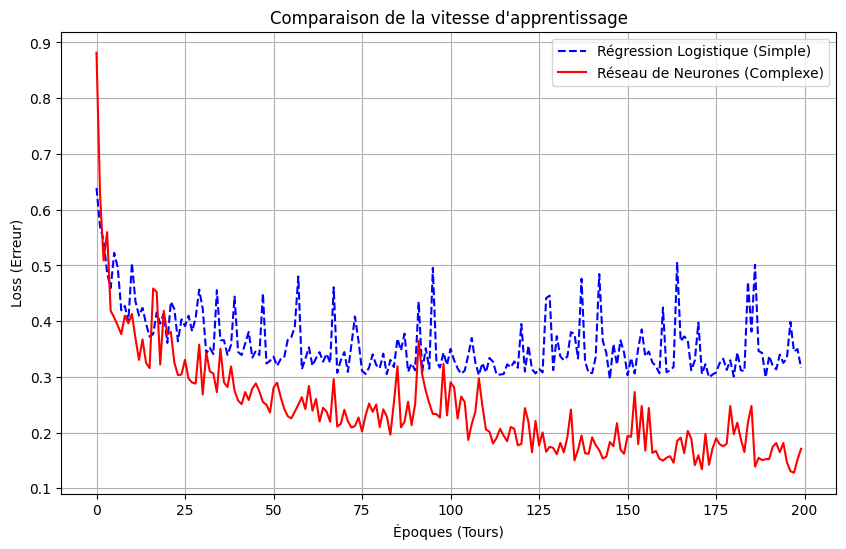

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Régression Logistique (Simple)', color='blue', linestyle='--')
plt.plot(loss_history_mlp, label='Réseau de Neurones (Complexe)', color='red')

plt.xlabel('Époques (Tours)')
plt.ylabel('Loss (Erreur)')
plt.title('Comparaison de la vitesse d\'apprentissage')
plt.legend()
plt.grid(True)
plt.show()